## Intro

TODO

In [1]:
import os
import glob
import pickle
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from scipy import stats
from scipy.stats import randint
import matplotlib.dates as mdates

from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

## Understanding the dataset

In [2]:
df_raw = pd.read_csv('data/Missing_Migrants_Global_Figures_allData.csv')

print(f"Data loaded with shape: {df_raw.shape}")
df_raw.head()

Data loaded with shape: (19897, 25)


,Main ID,Incident ID,Incident Type,Region of Incident,Incident Date,Incident Year,Month,Number of Dead,Minimum Estimated Number of Missing,Total Number of Dead and Missing,...,Region of Origin,Cause of Death,Country of Incident,Migration Route,Location of Incident,Coordinates,UNSD Geographical Grouping,Information Source,URL,Source Quality
0,2014.MMP00001,2014.MMP00001,Incident,North America,2014-01-06,2014,January,1.0,0.0,1,...,Central America,Mixed or unknown,United States of America,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,"31.650259, -110.366453",Northern America,Pima County Office of the Medical Examiner (PC...,http://humaneborders.info/,5
1,2014.MMP00002,2014.MMP00002,Incident,North America,2014-01-12,2014,January,1.0,0.0,1,...,Latin America / Caribbean (P),Mixed or unknown,United States of America,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,"31.59713, -111.73756",Northern America,Pima County Office of the Medical Examiner (PC...,NaN,5
2,2014.MMP00003,2014.MMP00003,Incident,North America,2014-01-14,2014,January,1.0,0.0,1,...,Latin America / Caribbean (P),Mixed or unknown,United States of America,US-Mexico border crossing,Pima Country Office of the Medical Examiner ju...,"31.94026, -113.01125",Northern America,Pima County Office of the Medical Examiner (PC...,NaN,5
3,2014.MMP00004,2014.MMP00004,Incident,North America,2014-01-16,2014,January,1.0,0.0,1,...,Central America,Violence,United States of America,US-Mexico border crossing,"near Douglas, Arizona, USA","31.506777, -109.315632",Northern America,"Ministry of Foreign Affairs Mexico, Pima Count...",http://bit.ly/1qfIw00,5
4,2014.MMP00005,2014.MMP00005,Incident,Europe,2014-01-16,2014,January,1.0,0.0,1,...,Northern Africa,Harsh environmental conditions / lack of adequ...,Russian Federation,NaN,Border between Russia and Estonia,"59.1551, 28",Northern Europe,EUBusiness (Agence France-Presse),http://bit.ly/1rTFTjR,1


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19897 entries, 0 to 19896
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Main ID                              19897 non-null  object 
 1   Incident ID                          19897 non-null  object 
 2   Incident Type                        19897 non-null  object 
 3   Region of Incident                   19897 non-null  object 
 4   Incident Date                        19897 non-null  object 
 5   Incident Year                        19897 non-null  int64  
 6   Month                                19897 non-null  object 
 7   Number of Dead                       19124 non-null  float64
 8   Minimum Estimated Number of Missing  19839 non-null  float64
 9   Total Number of Dead and Missing     19897 non-null  int64  
 10  Number of Survivors                  2988 non-null   float64
 11  Number of Females           

In [4]:
df_raw.columns

Index(['Main ID', 'Incident ID', 'Incident Type', 'Region of Incident',
       'Incident Date', 'Incident Year', 'Month', 'Number of Dead',
       'Minimum Estimated Number of Missing',
       'Total Number of Dead and Missing', 'Number of Survivors',
       'Number of Females', 'Number of Males', 'Number of Children',
       'Country of Origin', 'Region of Origin', 'Cause of Death',
       'Country of Incident', 'Migration Route', 'Location of Incident',
       'Coordinates', 'UNSD Geographical Grouping', 'Information Source',
       'URL', 'Source Quality'],
      dtype='object')

In [5]:
df_raw['Incident Type'].unique()

array(['Incident', 'Cumulative Incident', 'Split Incident',
       'Incident,Split Incident'], dtype=object)

In [6]:
incident_types = df_raw['Incident Type'].value_counts()
print("Incident Type Distribution:")
print(incident_types)
print(f"\nPercentage of each type:")
print((incident_types / len(df_raw) * 100).round(1))

Incident Type Distribution:
Incident Type
Incident                   19372
Split Incident               420
Cumulative Incident           95
Incident,Split Incident       10
Name: count, dtype: int64

Percentage of each type:
Incident Type
Incident                   97.4
Split Incident              2.1
Cumulative Incident         0.5
Incident,Split Incident     0.1
Name: count, dtype: float64


In [7]:
df_raw[df_raw['Incident Type'] == 'Incident'].shape

(19372, 25)

In [8]:
df_raw['Cause of Death'].unique()

array(['Mixed or unknown', 'Violence',
       'Harsh environmental conditions / lack of adequate shelter, food, water',
       'Drowning',
       'Vehicle accident / death linked to hazardous transport',
       'Sickness / lack of access to adequate healthcare',
       'Accidental death', 'Drowning,Mixed or unknown',
       'Drowning,Harsh environmental conditions / lack of adequate shelter, food, water',
       'Drowning,Vehicle accident / death linked to hazardous transport',
       'Harsh environmental conditions / lack of adequate shelter, food, water,Sickness / lack of access to adequate healthcare',
       'Harsh environmental conditions / lack of adequate shelter, food, water,Mixed or unknown',
       'Drowning,Violence',
       'Mixed or unknown,Vehicle accident / death linked to hazardous transport,Violence',
       'Drowning,Sickness / lack of access to adequate healthcare',
       'Accidental death,Drowning',
       'Mixed or unknown,Sickness / lack of access to adequate hea

## Data preprocessing

In [9]:
df_filtered = df_raw.copy()

In [10]:
df_filtered = df_filtered[df_filtered['Incident Type'] == 'Incident']

In [11]:
cause_value_map = {
    'Mixed or unknown': 'UnknownCause',
    'Violence': 'Violence',
    'Harsh environmental conditions / lack of adequate shelter, food, water': 'HarshEnvConditions',
    'Drowning': 'Drowning',
    'Vehicle accident / death linked to hazardous transport': 'VehicleAccident',
    'Sickness / lack of access to adequate healthcare': 'Sickness',
    'Accidental death': 'AccidentalDeath',
    'Drowning,Mixed or unknown': 'Drowning + UnknownCause',
    'Drowning,Harsh environmental conditions / lack of adequate shelter, food, water': 'Drowning + HarshEnvConditions',
    'Drowning,Vehicle accident / death linked to hazardous transport': 'Drowning + VehicleAccident',
    'Harsh environmental conditions / lack of adequate shelter, food, water,Sickness / lack of access to adequate healthcare': 'HarshEnvConditions + Sickness',
    'Harsh environmental conditions / lack of adequate shelter, food, water,Mixed or unknown': 'HarshEnvConditions + UnknownCause',
    'Drowning,Violence': 'Drowning + Violence',
    'Mixed or unknown,Vehicle accident / death linked to hazardous transport,Violence': 'UnknownCause + VehicleAccident + Violence',
    'Drowning,Sickness / lack of access to adequate healthcare': 'Drowning + Sickness',
    'Accidental death,Drowning': 'AccidentalDeath + Drowning',
    'Mixed or unknown,Sickness / lack of access to adequate healthcare': 'UnknownCause + Sickness'
}

df_filtered['Cause of Death'] = df_filtered['Cause of Death'].replace(cause_value_map)

In [12]:
column_rename_map = {
    'Region of Incident': 'region_incident',
    'Incident Date': 'incident_date',
    'Incident Year': 'incident_year',
    'Month': 'month_name',
    'Number of Dead': 'num_dead',
    'Minimum Estimated Number of Missing': 'min_est_missing',
    'Total Number of Dead and Missing': 'total_dead_missing',
    'Number of Survivors': 'num_survivors',
    'Number of Females': 'num_females',
    'Number of Males': 'num_males',
    'Number of Children': 'num_children',
    'Country of Origin': 'country_origin',
    'Region of Origin': 'region_origin',
    'Cause of Death': 'cause_death',
    'Country of Incident': 'country_incident',
    'Migration Route': 'migration_route',
    'Coordinates': 'coordinates',
    'UNSD Geographical Grouping': 'unsd_geo_grouping',
}

df_filtered = df_filtered.rename(columns=column_rename_map)

In [13]:
df_filtered['incident_date'] = pd.to_datetime(df_filtered['incident_date'], format='%Y-%m-%d')

df_filtered['incident_month'] = df_filtered['incident_date'].dt.month
df_filtered['incident_week'] = df_filtered['incident_date'].dt.isocalendar().week.astype(int)

In [14]:
# convert coordinates from string to tuple

def convert_coordinates(coord_str):
    if pd.isna(coord_str):
        return None
    try:
        lat, lon = map(float, coord_str.split(','))
        return (lat, lon)
    except ValueError:
        return None
df_filtered['coordinates'] = df_filtered['coordinates'].apply(convert_coordinates)

In [15]:
df_filtered.columns

Index(['Main ID', 'Incident ID', 'Incident Type', 'region_incident',
       'incident_date', 'incident_year', 'month_name', 'num_dead',
       'min_est_missing', 'total_dead_missing', 'num_survivors', 'num_females',
       'num_males', 'num_children', 'country_origin', 'region_origin',
       'cause_death', 'country_incident', 'migration_route',
       'Location of Incident', 'coordinates', 'unsd_geo_grouping',
       'Information Source', 'URL', 'Source Quality', 'incident_month',
       'incident_week'],
      dtype='object')

In [16]:
filtered_cols = [
    'region_incident', 'country_incident', 'incident_date', 'incident_year', 'incident_month', 'incident_week',
    'region_origin', 'country_origin', 'cause_death', 'migration_route',  'coordinates',
    'min_est_missing', 'total_dead_missing', 'num_survivors','num_females', 'num_males', 'num_children', 'num_dead'
]

df_filtered = df_filtered[filtered_cols].copy()

In [17]:
df_filtered.isnull().sum()

,0
region_incident,0
country_incident,0
incident_date,0
incident_year,0
incident_month,0
incident_week,0
region_origin,0
country_origin,3
cause_death,0
migration_route,2544


In [18]:
print("=== MISSING DATA ANALYSIS ===")
missing_data = df_filtered.isnull().sum()
missing_pct = (missing_data / len(df_filtered) * 100).round(1)
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

print()
categorical_cols = ['country_origin', 'migration_route']
for col in categorical_cols:
    df_filtered[col] = df_filtered[col].fillna('Unknown').astype(str)
    print(f"Fixed {col}: filled {missing_data[col]} NaN values with 'Unknown'")

numerical_cols = ['min_est_missing', 'num_survivors', 'num_females', 'num_males', 'num_children', 'num_dead']
for col in numerical_cols:
    df_filtered[col] = df_filtered[col].fillna(0)
    print(f"Fixed {col}: filled {missing_data[col]} NaN values with 0")

print(f"\n=== VERIFICATION ===")
remaining_missing = df_filtered.isnull().sum().sum()
print(f"Total missing values after cleaning: {remaining_missing}")

=== MISSING DATA ANALYSIS ===
                 Missing_Count  Missing_Percentage
num_survivors            16654                86.0
num_children             15181                78.4
num_females              13730                70.9
num_males                 6276                32.4
migration_route           2544                13.1
num_dead                   699                 3.6
min_est_missing             55                 0.3
country_origin               3                 0.0

Fixed country_origin: filled 3 NaN values with 'Unknown'
Fixed migration_route: filled 2544 NaN values with 'Unknown'
Fixed min_est_missing: filled 55 NaN values with 0
Fixed num_survivors: filled 16654 NaN values with 0
Fixed num_females: filled 13730 NaN values with 0
Fixed num_males: filled 6276 NaN values with 0
Fixed num_children: filled 15181 NaN values with 0
Fixed num_dead: filled 699 NaN values with 0

=== VERIFICATION ===
Total missing values after cleaning: 0


In [19]:
print('DataFrame Info:')
print(df_filtered.info())

print('\nDataFrame:')
df_filtered.head()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 19372 entries, 0 to 19896
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   region_incident     19372 non-null  object        
 1   country_incident    19372 non-null  object        
 2   incident_date       19372 non-null  datetime64[ns]
 3   incident_year       19372 non-null  int64         
 4   incident_month      19372 non-null  int32         
 5   incident_week       19372 non-null  int64         
 6   region_origin       19372 non-null  object        
 7   country_origin      19372 non-null  object        
 8   cause_death         19372 non-null  object        
 9   migration_route     19372 non-null  object        
 10  coordinates         19372 non-null  object        
 11  min_est_missing     19372 non-null  float64       
 12  total_dead_missing  19372 non-null  int64         
 13  num_survivors       19372 non-null 

,region_incident,country_incident,incident_date,incident_year,incident_month,incident_week,region_origin,country_origin,cause_death,migration_route,coordinates,min_est_missing,total_dead_missing,num_survivors,num_females,num_males,num_children,num_dead
0,North America,United States of America,2014-01-06,2014,1,2,Central America,Guatemala,UnknownCause,US-Mexico border crossing,"(31.650259, -110.366453)",0.0,1,0.0,0.0,1.0,0.0,1.0
1,North America,United States of America,2014-01-12,2014,1,2,Latin America / Caribbean (P),Unknown,UnknownCause,US-Mexico border crossing,"(31.59713, -111.73756)",0.0,1,0.0,1.0,0.0,0.0,1.0
2,North America,United States of America,2014-01-14,2014,1,3,Latin America / Caribbean (P),Unknown,UnknownCause,US-Mexico border crossing,"(31.94026, -113.01125)",0.0,1,0.0,0.0,1.0,0.0,1.0
3,North America,United States of America,2014-01-16,2014,1,3,Central America,Mexico,Violence,US-Mexico border crossing,"(31.506777, -109.315632)",0.0,1,0.0,0.0,1.0,0.0,1.0
4,Europe,Russian Federation,2014-01-16,2014,1,3,Northern Africa,Sudan,HarshEnvConditions,Unknown,"(59.1551, 28.0)",0.0,1,2.0,0.0,1.0,0.0,1.0


## EDA

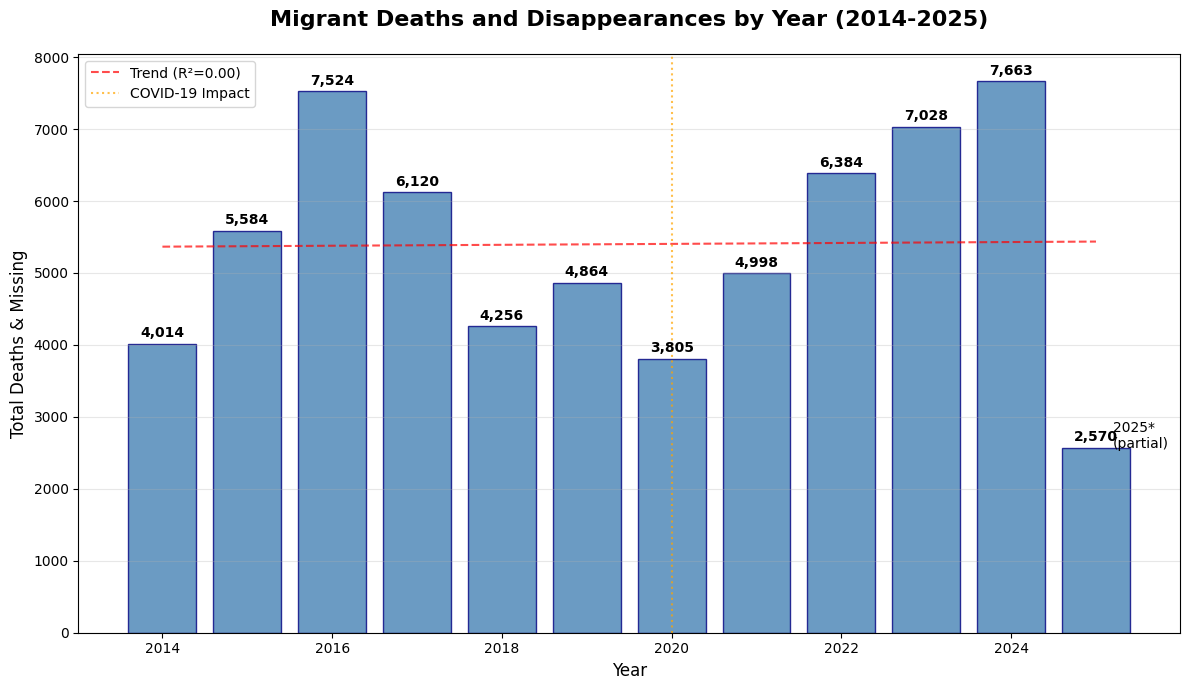

Peak year: 2024 with 7,663 deaths
Total deaths (2014-2025): 64,810
2020 dip: 1,059 fewer deaths vs 2019


In [20]:
yearly_deaths = df_filtered.groupby('incident_year')['total_dead_missing'].sum()

plt.figure(figsize=(12, 7))
bars = plt.bar(yearly_deaths.index, yearly_deaths.values, color='steelblue', alpha=0.8, edgecolor='navy')

for i, v in enumerate(yearly_deaths.values):
    plt.text(yearly_deaths.index[i], v + 50, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.title('Migrant Deaths and Disappearances by Year (2014-2025)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Deaths & Missing', fontsize=12)

slope, intercept, r_value, p_value, std_err = stats.linregress(yearly_deaths.index, yearly_deaths.values)
trend_line = slope * yearly_deaths.index + intercept
plt.plot(yearly_deaths.index, trend_line, '--', color='red', alpha=0.7, label=f'Trend (R²={r_value**2:.2f})')

plt.axvline(x=2020, color='orange', linestyle=':', alpha=0.7, label='COVID-19 Impact')
plt.text(2025.2, yearly_deaths[2025], '2025*\n(partial)', fontsize=10, ha='left')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Peak year: {yearly_deaths.idxmax()} with {yearly_deaths.max():,} deaths")
print(f"Total deaths (2014-2025): {yearly_deaths.sum():,}")
print(f"2020 dip: {yearly_deaths[2019] - yearly_deaths[2020]:,} fewer deaths vs 2019")

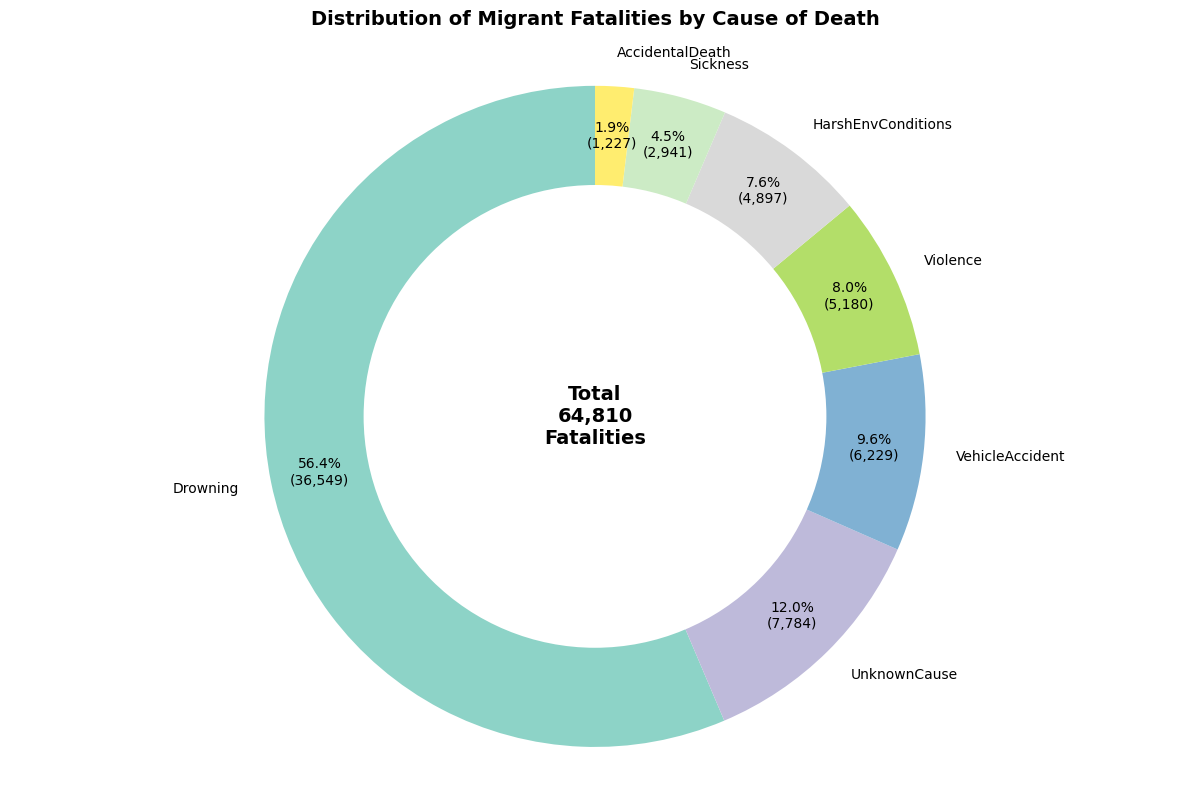

In [21]:
fatalities_by_cause = df_filtered.groupby('cause_death')['total_dead_missing'].sum().sort_values(ascending=False)

top_10_causes = fatalities_by_cause.head(10)
cumulative_pct = (top_10_causes.cumsum() / fatalities_by_cause.sum() * 100)

plt.figure(figsize=(12, 8))
top_causes = fatalities_by_cause.head(8)
others_sum = fatalities_by_cause.iloc[8:].sum()
plot_data = pd.concat([top_causes, pd.Series({'Others': others_sum})]) if others_sum > 0 else top_causes

colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
wedges, texts, autotexts = plt.pie(
    plot_data.values,
    labels=plot_data.index,
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*plot_data.sum()):,})',
    colors=colors,
    startangle=90,
    pctdistance=0.85
)

centre_circle = plt.Circle((0,0), 0.70, fc='white')
plt.gca().add_artist(centre_circle)
plt.text(0, 0, f'Total\n{fatalities_by_cause.sum():,}\nFatalities', ha='center', va='center', fontsize=14, fontweight='bold')
plt.title('Distribution of Migrant Fatalities by Cause of Death', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()


--- Top 5 Migration Routes by Fatalities ---
['Central Mediterranean', 'Unknown', 'Sahara Desert crossing', 'US-Mexico border crossing', 'Western Africa / Atlantic route to the Canary Islands']


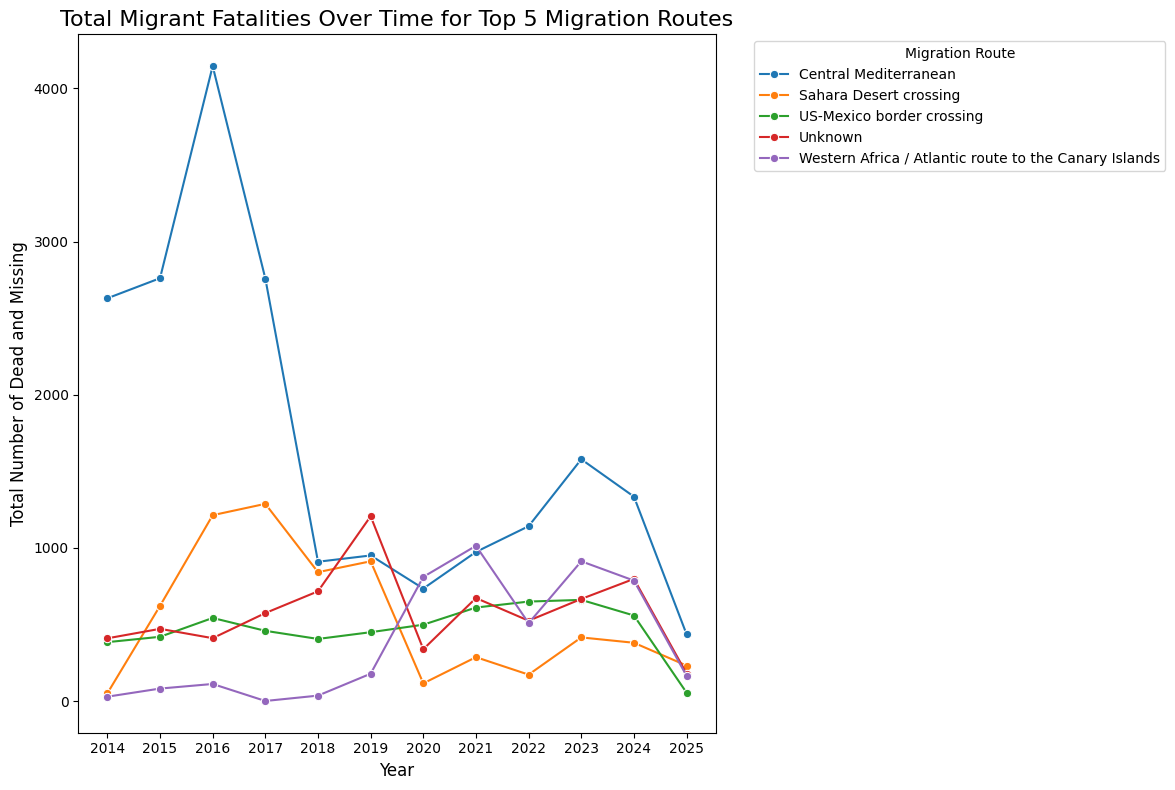

In [22]:
top_routes = df_filtered.groupby('migration_route')['total_dead_missing'].sum().nlargest(5).index

df_top_routes = df_filtered[df_filtered['migration_route'].isin(top_routes)]

fatalities_by_route_year = df_top_routes.groupby(['incident_year', 'migration_route'])['total_dead_missing'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(data=fatalities_by_route_year, x='incident_year', y='total_dead_missing', hue='migration_route', marker='o')
plt.title('Total Migrant Fatalities Over Time for Top 5 Migration Routes', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Number of Dead and Missing', fontsize=12)
plt.legend(title='Migration Route', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(fatalities_by_route_year['incident_year'].unique().astype(int))
plt.tight_layout()

print("\n--- Top 5 Migration Routes by Fatalities ---")
print(top_routes.to_list())


--- Top 5 Regions by Fatalities ---
['Mediterranean', 'Northern Africa', 'Southern Asia', 'North America', 'Western Africa']


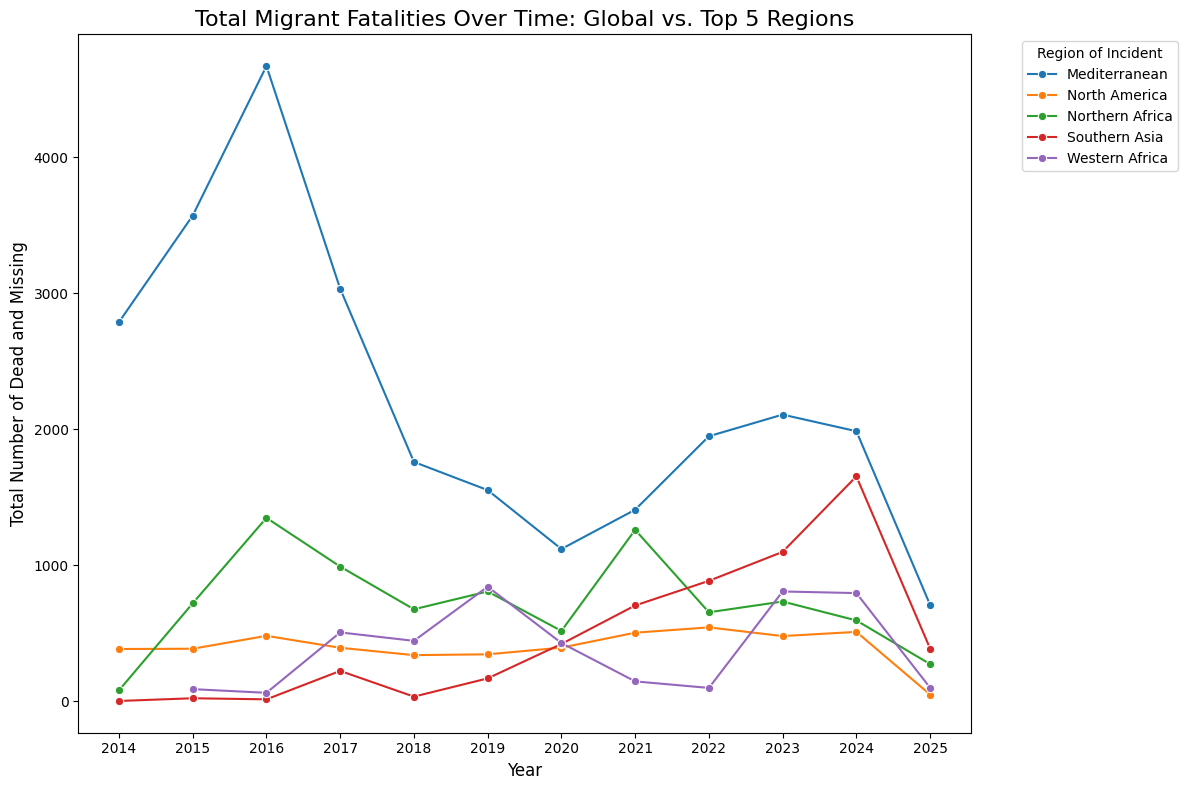

In [23]:
top_regions = df_filtered.groupby('region_incident')['total_dead_missing'].sum().nlargest(5).index.tolist()

df_top_regions = df_filtered[df_filtered['region_incident'].isin(top_regions)]

fatalities_by_region_year = df_top_regions.groupby(['incident_year', 'region_incident'])['total_dead_missing'].sum().reset_index()

plt.figure(figsize=(12, 8))
sns.lineplot(data=fatalities_by_region_year, x='incident_year', y='total_dead_missing', hue='region_incident', marker='o')
plt.title('Total Migrant Fatalities Over Time: Global vs. Top 5 Regions', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Number of Dead and Missing', fontsize=12)
plt.legend(title='Region of Incident', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(fatalities_by_region_year['incident_year'].unique().astype(int))
plt.tight_layout()

print("\n--- Top 5 Regions by Fatalities ---")
print(top_regions)

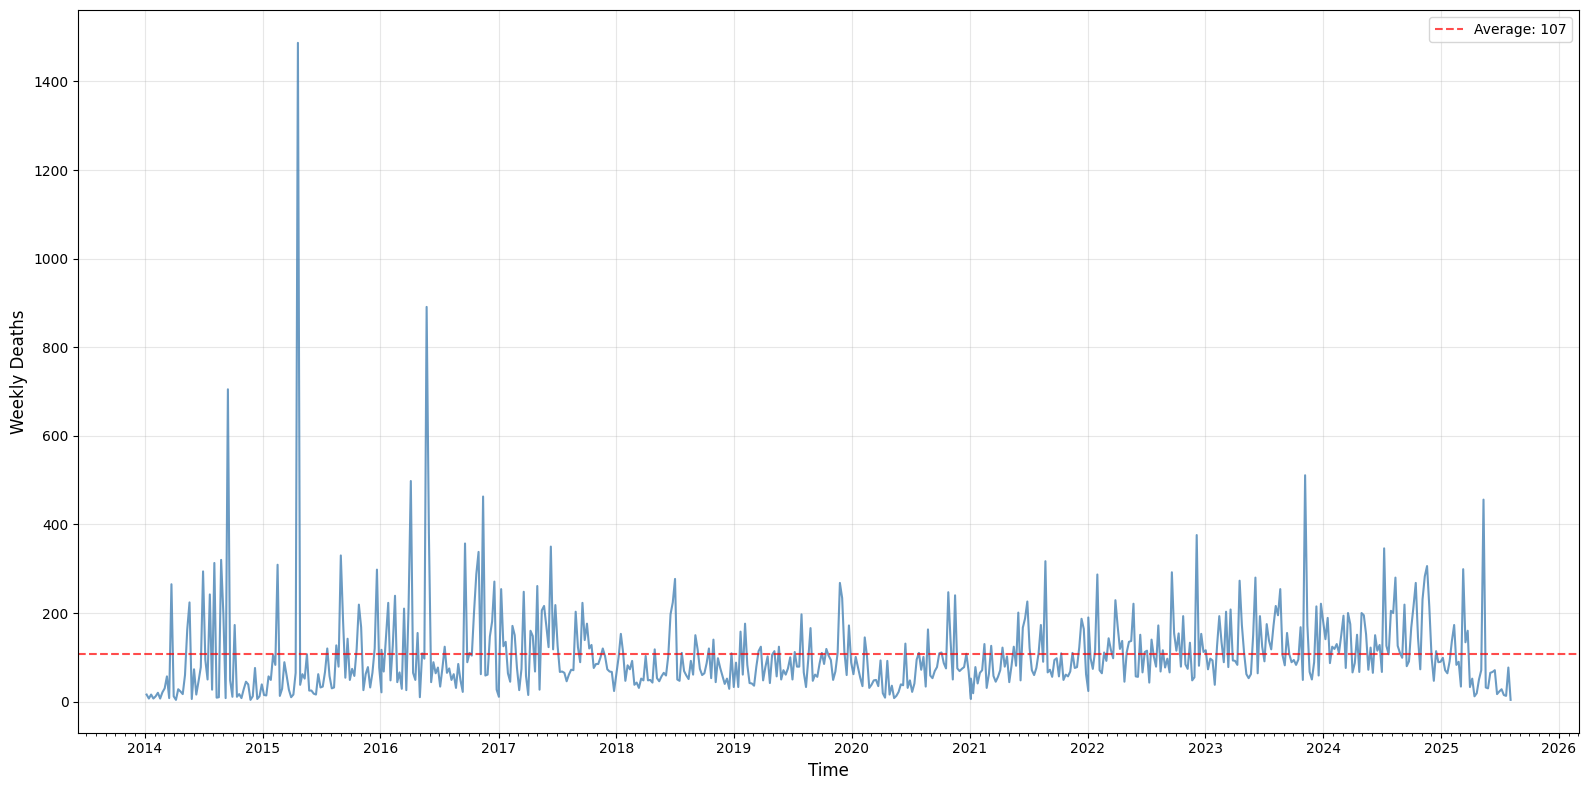

Average deaths by month:
January: 2.8
February: 3.0
March: 3.3
April: 4.6
May: 4.2
June: 3.2
July: 2.9
August: 3.3
September: 3.1
October: 3.2
November: 3.6
December: 3.4

Deadliest week: 2015 Week 16 with 1487 deaths
Safest week: 2014 Week 14 with 4 deaths


In [24]:
weekly_deaths = df_filtered.groupby(['incident_year', 'incident_week'])['total_dead_missing'].sum().reset_index()

weekly_deaths['week_date'] = pd.to_datetime(
    weekly_deaths['incident_year'].astype(str) + '-W' + weekly_deaths['incident_week'].astype(str) + '-1',
    format='%Y-W%U-%w'
)

weekly_deaths = weekly_deaths.sort_values('week_date')

plt.figure(figsize=(16, 8))
plt.plot(weekly_deaths['week_date'], weekly_deaths['total_dead_missing'], color='steelblue', linewidth=1.5, alpha=0.8)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Weekly Deaths', fontsize=12)
plt.axhline(y=weekly_deaths['total_dead_missing'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Average: {weekly_deaths["total_dead_missing"].mean():.0f}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.tight_layout()
plt.show()

monthly_avg = df_filtered.groupby('incident_month')['total_dead_missing'].mean()
print("Average deaths by month:")
for month, avg in monthly_avg.items():
    month_name = pd.to_datetime(f'2024-{month:02d}-01').strftime('%B')
    print(f"{month_name}: {avg:.1f}")

print(f"\nDeadliest week: {weekly_deaths.loc[weekly_deaths['total_dead_missing'].idxmax(), 'week_date'].strftime('%Y Week %U')} with {weekly_deaths['total_dead_missing'].max()} deaths")
print(f"Safest week: {weekly_deaths.loc[weekly_deaths['total_dead_missing'].idxmin(), 'week_date'].strftime('%Y Week %U')} with {weekly_deaths['total_dead_missing'].min()} deaths")

Loading world map data...
Using cached data/world_countries.geojson
Loaded 258 countries


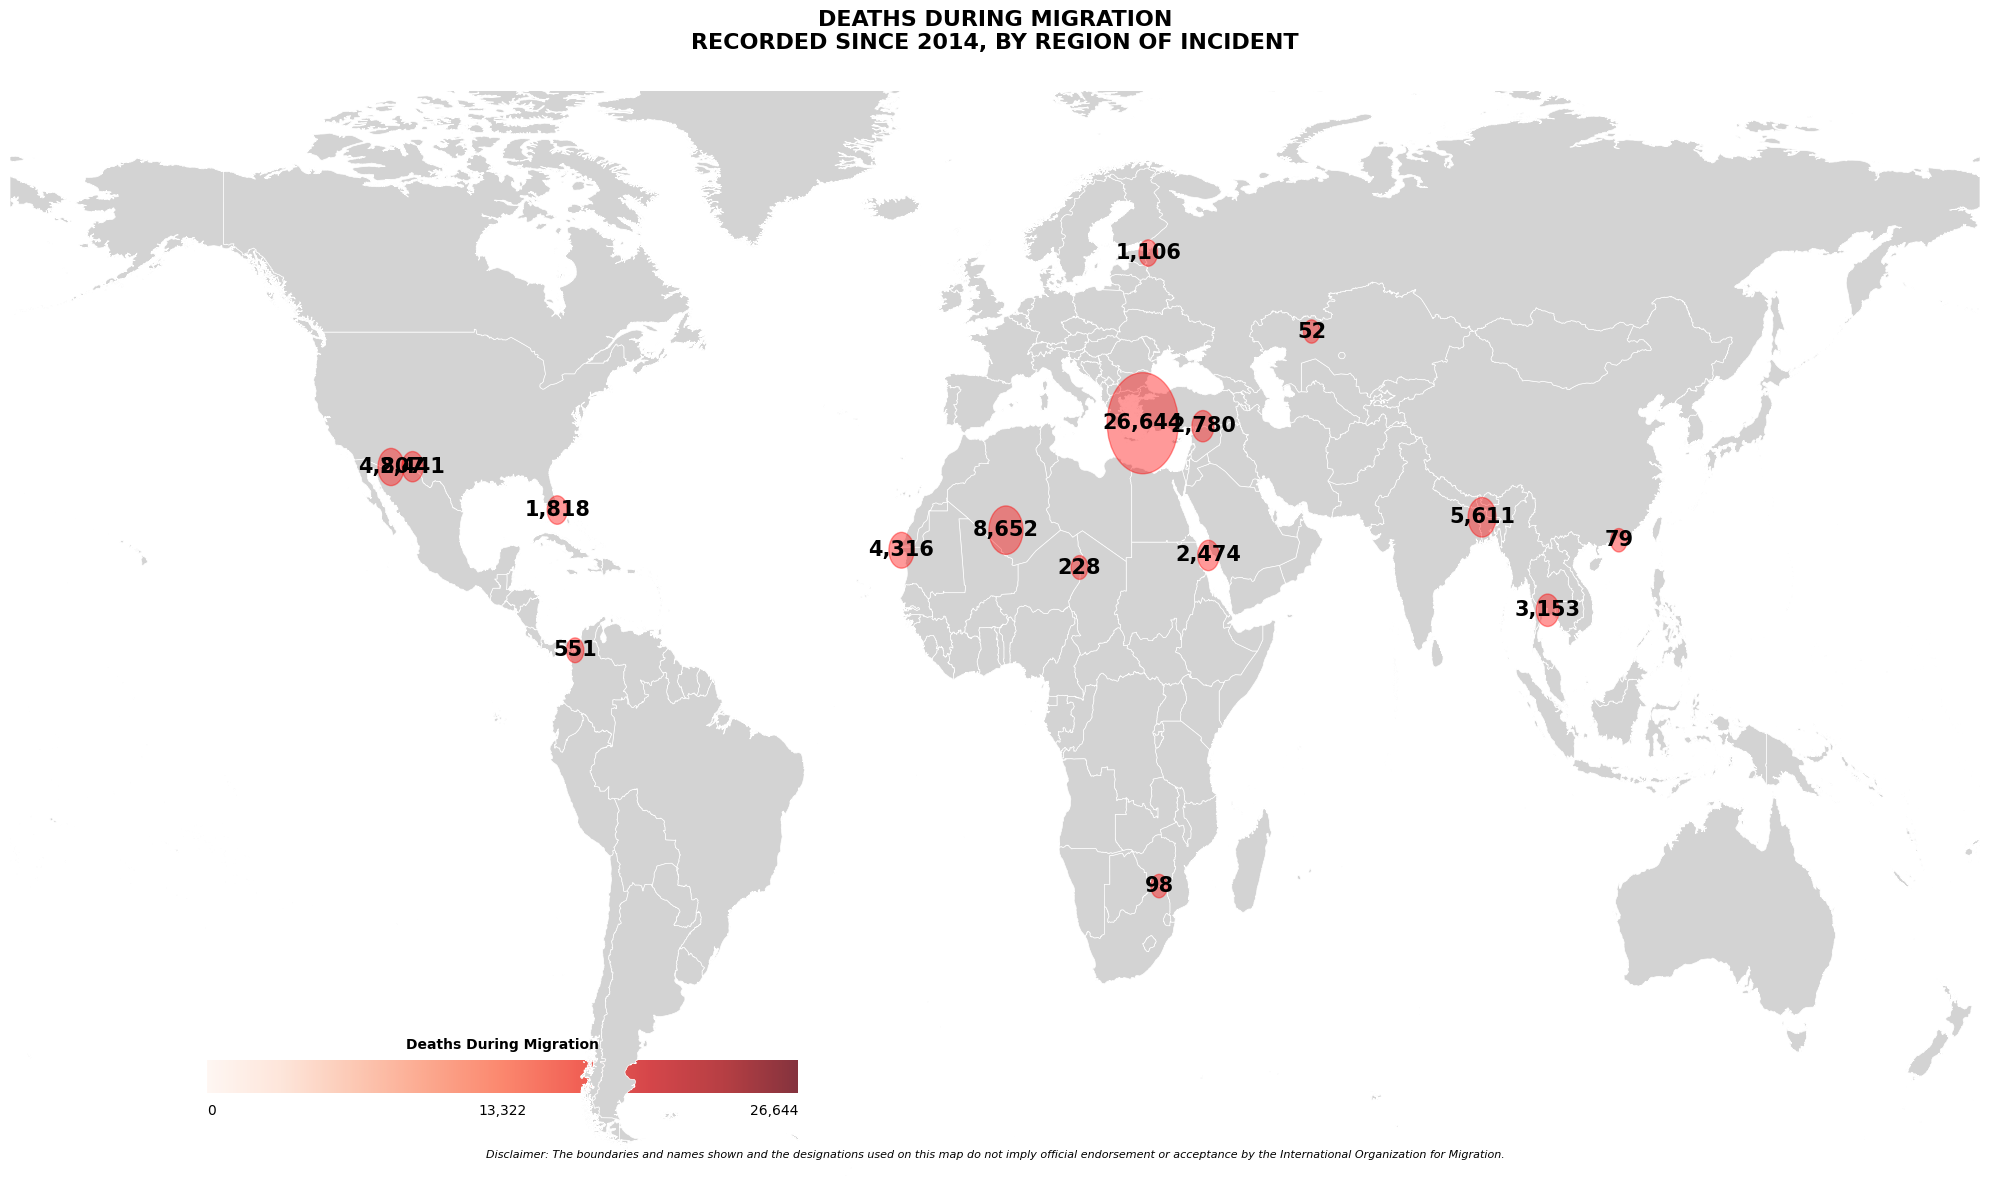


Summary:
Regions shown: 16
Total deaths recorded: 64,810

Regional breakdown:
Mediterranean: 26,644 (41.1%)
Northern Africa: 8,652 (13.3%)
Southern Asia: 5,611 (8.7%)
North America: 4,807 (7.4%)
Western Africa: 4,316 (6.7%)
South-eastern Asia: 3,153 (4.9%)
Western Asia: 2,780 (4.3%)
Eastern Africa: 2,474 (3.8%)
Central America: 2,441 (3.8%)
Caribbean: 1,818 (2.8%)
Europe: 1,106 (1.7%)
South America: 551 (0.9%)
Middle Africa: 228 (0.4%)
Southern Africa: 98 (0.2%)
Eastern Asia: 79 (0.1%)
Central Asia: 52 (0.1%)


In [25]:
world = gpd.read_file('data/world_countries.geojson')
print(f"Loaded {len(world)} countries")

regional_deaths = df_filtered.groupby('region_incident')['total_dead_missing'].sum().reset_index()

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

world.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)

region_coords = df_filtered.groupby('region_incident')['coordinates'].first().apply(lambda x: eval(x) if isinstance(x, str) else x).to_dict()

max_deaths = regional_deaths['total_dead_missing'].max()
min_deaths = regional_deaths['total_dead_missing'].min()

for _, row in regional_deaths.iterrows():
    region = row['region_incident']
    deaths = row['total_dead_missing']

    if region in region_coords:
        coord = region_coords[region]

        death_ratio = (deaths - min_deaths) / (max_deaths - min_deaths)
        bubble_size = 1.5 + death_ratio * 5

        circle = plt.Circle((coord[1], coord[0]), bubble_size, color='#FF0000', alpha=0.4, zorder=5, linewidth=1)
        ax.add_patch(circle)

        ax.text(coord[1], coord[0], f'{deaths:,}', ha='center', va='center', fontsize=15, fontweight='bold', color='black', zorder=6)

ax.set_title('DEATHS DURING MIGRATION\nRECORDED SINCE 2014, BY REGION OF INCIDENT', fontsize=16, fontweight='bold', pad=30, ha='center')

ax.set_xlim(-180, 180)
ax.set_ylim(-60, 80)
ax.axis('off')

ax.text(0.5, 0.02, 'Disclaimer: The boundaries and names shown and the designations used on this map do not imply official endorsement or acceptance by the International Organization for Migration.', transform=ax.transAxes, ha='center', fontsize=8, style='italic')

legend_x = 0.1
legend_y = 0.08
legend_width = 0.3
legend_height = 0.03

gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack((gradient, gradient))

ax.imshow(gradient, extent=[legend_x, legend_x + legend_width, legend_y, legend_y + legend_height], transform=ax.transAxes, aspect='auto', cmap='Reds', alpha=0.8)

ax.text(legend_x, legend_y - 0.02, '0', transform=ax.transAxes, fontsize=10, ha='left')
ax.text(legend_x + legend_width/2, legend_y - 0.02, f'{max_deaths//2:,}', transform=ax.transAxes, fontsize=10, ha='center')
ax.text(legend_x + legend_width, legend_y - 0.02, f'{max_deaths:,}', transform=ax.transAxes, fontsize=10, ha='right')
ax.text(legend_x + legend_width/2, legend_y + legend_height + 0.01, 'Deaths During Migration', transform=ax.transAxes, fontsize=10, ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSummary:")
print(f"Regions shown: {len(regional_deaths)}")
print(f"Total deaths recorded: {regional_deaths['total_dead_missing'].sum():,}")

print("\nRegional breakdown:")
total_deaths = regional_deaths['total_dead_missing'].sum()
for _, row in regional_deaths.sort_values('total_dead_missing', ascending=False).iterrows():
    percentage = (row['total_dead_missing'] / total_deaths) * 100
    print(f"{row['region_incident']}: {row['total_dead_missing']:,} ({percentage:.1f}%)")

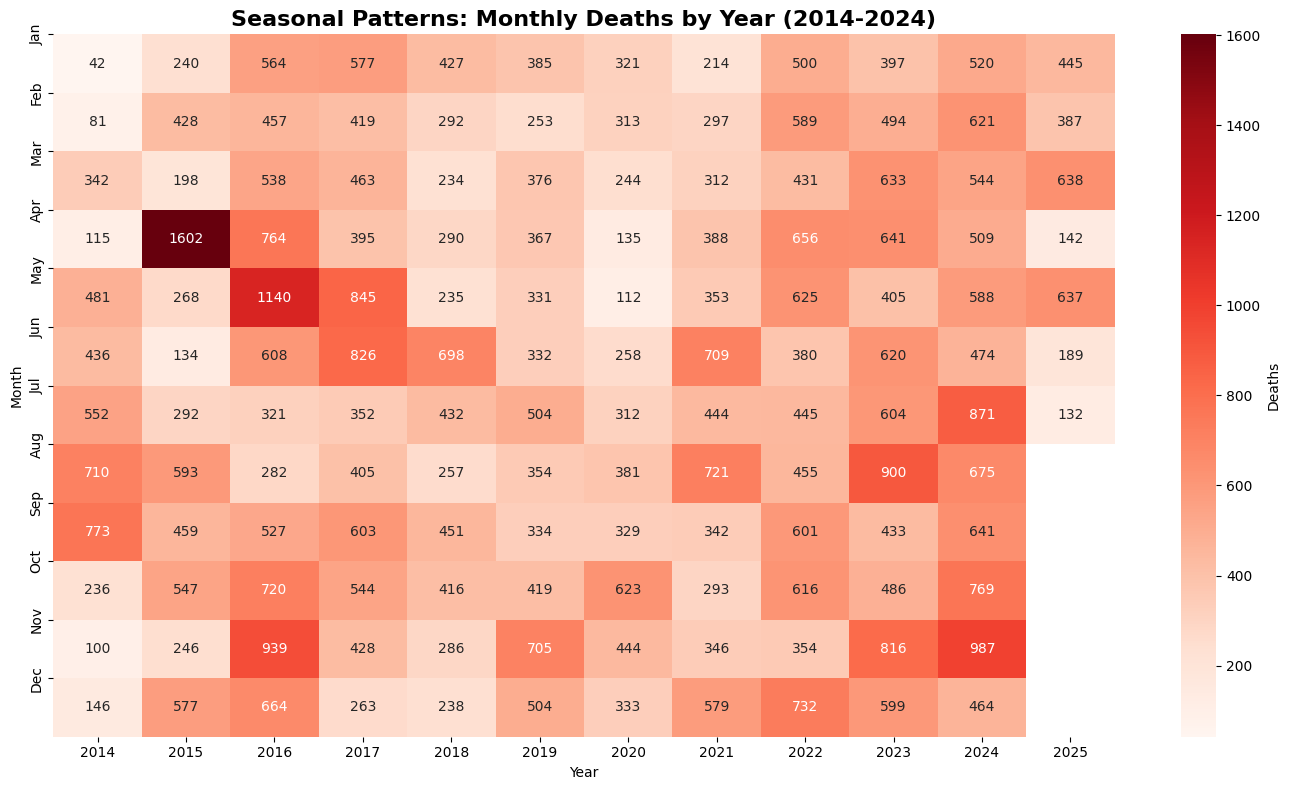

In [26]:
monthly_yearly = df_filtered.groupby(['incident_year', 'incident_month'])['total_dead_missing'].sum().reset_index()
heatmap_data = monthly_yearly.pivot(index='incident_month', columns='incident_year', values='total_dead_missing')

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='Reds', cbar_kws={'label': 'Deaths'})
plt.title('Seasonal Patterns: Monthly Deaths by Year (2014-2024)', fontsize=16, fontweight='bold')
plt.ylabel('Month')
plt.xlabel('Year')
plt.yticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

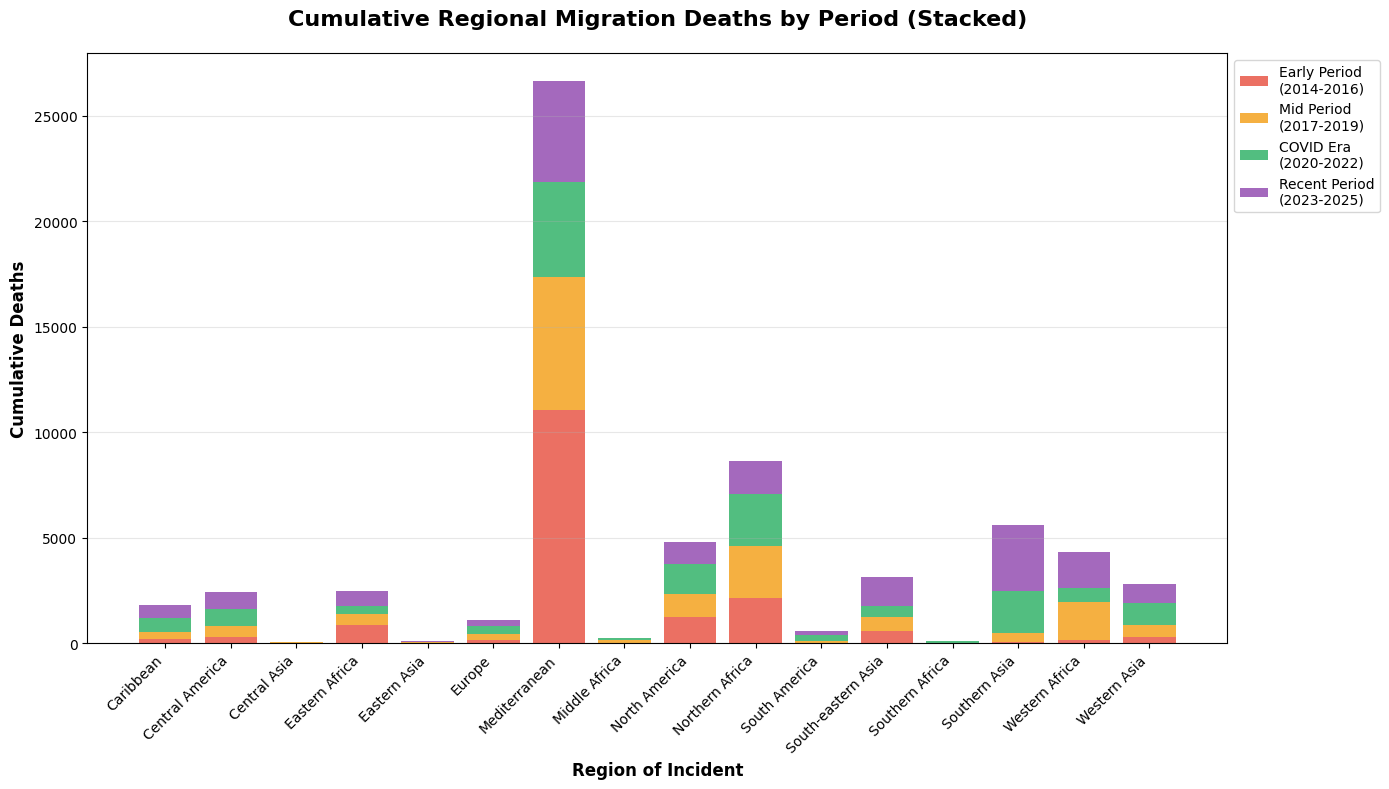

In [27]:
periods = [
    (2014, 2016, "Early Period\n(2014-2016)"),
    (2017, 2019, "Mid Period\n(2017-2019)"),
    (2020, 2022, "COVID Era\n(2020-2022)"),
    (2023, 2025, "Recent Period\n(2023-2025)")
]

period_data = {}
all_regions = set()

for start_year, end_year, title in periods:
    period_df = df_filtered[
        (df_filtered['incident_year'] >= start_year) & (df_filtered['incident_year'] <= end_year)
    ]
    regional_deaths = period_df.groupby('region_incident')['total_dead_missing'].sum()
    period_data[title] = regional_deaths
    all_regions.update(regional_deaths.index)

all_regions = sorted(list(all_regions))
plot_data = pd.DataFrame(index=all_regions)

for period_name, deaths_data in period_data.items():
    plot_data[period_name] = deaths_data.reindex(all_regions, fill_value=0)

fig, ax = plt.subplots(figsize=(14, 8))

bottom = np.zeros(len(all_regions))
colors = ['#e74c3c', '#f39c12', '#27ae60', '#8e44ad', '#2c3e50', '#3498db']
for i, (period, color) in enumerate(zip(plot_data.columns, colors)):
    bars = ax.bar(all_regions, plot_data[period], bottom=bottom, label=period, color=color, alpha=0.8)
    bottom += plot_data[period]

ax.set_xlabel('Region of Incident', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Deaths', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Regional Migration Deaths by Period (Stacked)', fontsize=16, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

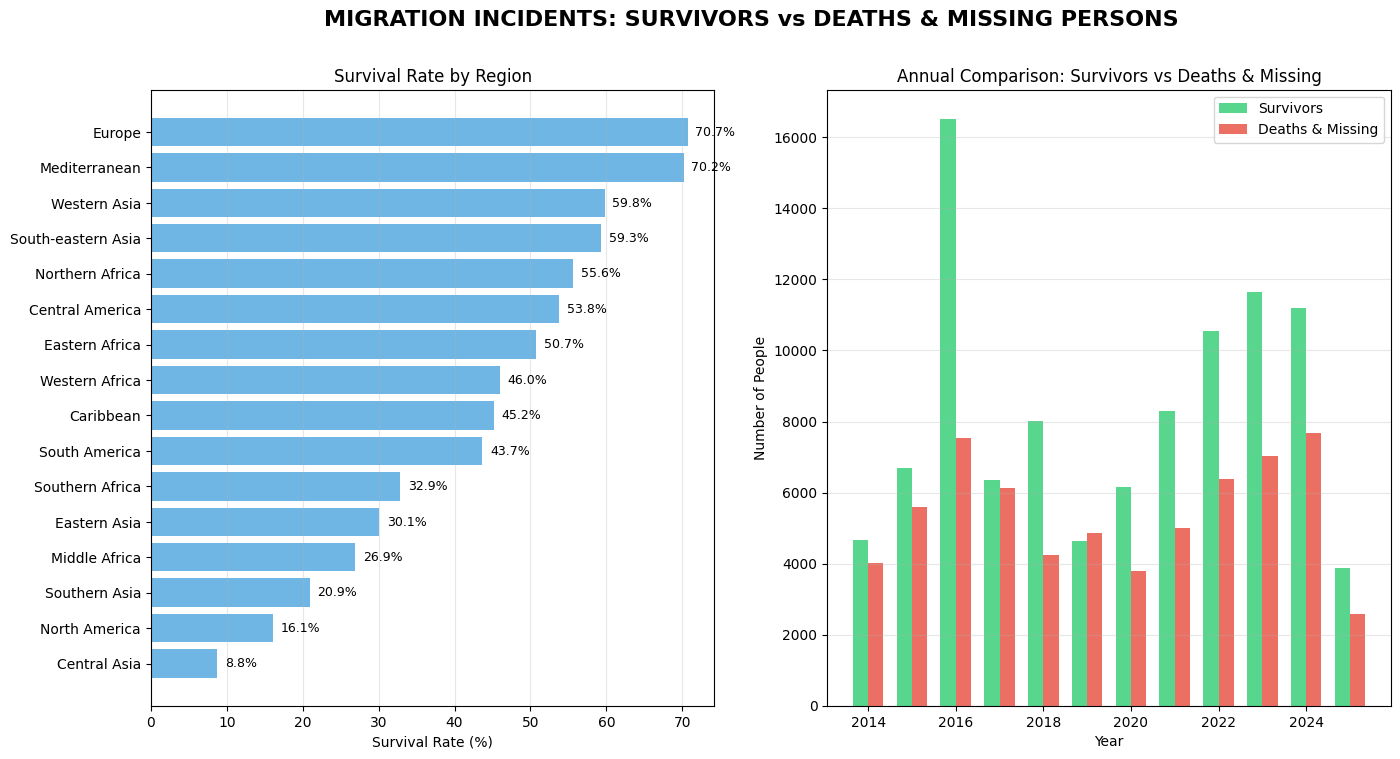

In [28]:
yearly_survivors = df_filtered.groupby('incident_year')['num_survivors'].sum()
yearly_deaths = df_filtered.groupby('incident_year')['total_dead_missing'].sum()

x_years = yearly_survivors.index
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1]})
fig.suptitle('MIGRATION INCIDENTS: SURVIVORS vs DEATHS & MISSING PERSONS', fontsize=16, fontweight='bold')

regional_stats = df_filtered.groupby('region_incident').agg({
    'num_survivors': 'sum',
    'total_dead_missing': 'sum'
}).reset_index()

regional_stats['total_people'] = regional_stats['num_survivors'] + regional_stats['total_dead_missing']
regional_stats['survival_rate'] = (regional_stats['num_survivors'] / regional_stats['total_people']) * 100
regional_stats = regional_stats.sort_values('survival_rate', ascending=True)

bars = axes[0].barh(regional_stats['region_incident'], regional_stats['survival_rate'], color='#3498db', alpha=0.7)
axes[0].set_title('Survival Rate by Region')
axes[0].set_xlabel('Survival Rate (%)')
axes[0].grid(axis='x', alpha=0.3)

for i, (bar, rate) in enumerate(zip(bars, regional_stats['survival_rate'])):
    axes[0].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{rate:.1f}%', va='center', fontsize=9)


axes[1].bar(x_years - width/2, yearly_survivors, width, label='Survivors', color='#2ecc71', alpha=0.8)
axes[1].bar(x_years + width/2, yearly_deaths, width, label='Deaths & Missing', color='#e74c3c', alpha=0.8)
axes[1].set_title('Annual Comparison: Survivors vs Deaths & Missing')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of People')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)


In [29]:
print("="*80)
print("COMPREHENSIVE RQ1 ANALYSIS: SPATIOTEMPORAL PATTERNS")
print("="*80)

print("\nTEMPORAL TREND ANALYSIS:")
yearly_data = df_filtered.groupby('incident_year')['total_dead_missing'].sum()

slope, intercept, r_value, p_value, std_err = stats.linregress(yearly_data.index, yearly_data.values)
print(f"   Overall trend: {slope:+.1f} deaths/year (R²={r_value**2:.3f}, p={p_value:.3f})")

pre_covid = yearly_data[yearly_data.index < 2020].mean()
covid_era = yearly_data[yearly_data.index >= 2020].mean()
print(f"   Pre-COVID average (2014-2019): {pre_covid:.0f} deaths/year")
print(f"   COVID+ era average (2020-2025): {covid_era:.0f} deaths/year")
print(f"   Change: {((covid_era - pre_covid) / pre_covid * 100):+.1f}%")

print("\nSPATIAL PATTERN ANALYSIS:")
periods = [(2014, 2017), (2018, 2021), (2022, 2025)]
period_names = ["Early (2014-2017)", "Mid (2018-2021)", "Recent (2022-2025)"]

regional_shifts = {}
for i, ((start, end), name) in enumerate(zip(periods, period_names)):
    period_data = df_filtered[(df_filtered['incident_year'] >= start) & (df_filtered['incident_year'] <= end)]
    regional_totals = period_data.groupby('region_incident')['total_dead_missing'].sum()
    regional_shifts[name] = regional_totals / regional_totals.sum() * 100  # Convert to percentages

shift_df = pd.DataFrame(regional_shifts).fillna(0)

print("   Regional percentage share by period:")
for region in shift_df.index:
    changes = []
    for i in range(1, len(shift_df.columns)):
        prev_pct = shift_df.iloc[:, i-1].loc[region]
        curr_pct = shift_df.iloc[:, i].loc[region]
        change = curr_pct - prev_pct
        changes.append(f"{change:+.1f}%")
    print(f"   {region}: {' → '.join(changes)}")

print("\nSEASONAL CONCENTRATION:")
monthly_totals = df_filtered.groupby('incident_month')['total_dead_missing'].sum()
monthly_pct = monthly_totals / monthly_totals.sum() * 100

equal_share = 100/12  # 8.33% if perfectly distributed
concentration = np.sum(np.abs(monthly_pct - equal_share)) / 2
print(f"   Seasonal concentration index: {concentration:.1f}% (0%=perfectly even, 50%=highly concentrated)")

peak_months = monthly_pct.nlargest(3)
print(f"   Peak months: {', '.join([pd.to_datetime(f'2024-{m:02d}-01').strftime('%B') for m in peak_months.index])}")
print(f"   Peak months account for {peak_months.sum():.1f}% of annual deaths")

print("\nMIGRATION ROUTE EVOLUTION:")
route_yearly = df_filtered.groupby(['migration_route', 'incident_year'])['total_dead_missing'].sum().reset_index()
top_routes = df_filtered.groupby('migration_route')['total_dead_missing'].sum().nlargest(3).index

for route in top_routes:
    route_data = route_yearly[route_yearly['migration_route'] == route]
    if len(route_data) > 3:  # Ensure we have enough data points
        slope, _, r_value, p_value, _ = stats.linregress(route_data['incident_year'], route_data['total_dead_missing'])
        trend = "increasing" if slope > 0 else "decreasing"
        print(f"   {route}: {slope:+.1f} deaths/year ({trend}, R²={r_value**2:.3f})")

print("\nHOTSPOT DYNAMICS:")
early_period = df_filtered[df_filtered['incident_year'] <= 2018]
recent_period = df_filtered[df_filtered['incident_year'] >= 2022]

early_regions = early_period.groupby('region_incident')['total_dead_missing'].sum()
recent_regions = recent_period.groupby('region_incident')['total_dead_missing'].sum()

emerging = recent_regions[~recent_regions.index.isin(early_regions.index)]
if len(emerging) > 0:
    print(f"   Emerging hotspots: {', '.join(emerging.nlargest(3).index)}")

for region in early_regions.index:
    if region in recent_regions.index:
        change_pct = ((recent_regions[region] - early_regions[region]) / early_regions[region]) * 100
        if change_pct < -50:  # Significant decline
            print(f"   Declining hotspot: {region} ({change_pct:+.1f}%)")

print("\n" + "="*80)
print("RQ1 SUMMARY: SPATIOTEMPORAL PATTERNS IDENTIFIED")
print("="*80)
print("Temporal trends quantified with statistical significance")
print("Regional shifts documented across multiple time periods")
print("Seasonal concentration patterns measured")
print("Migration route evolution tracked")
print("Hotspot emergence and decline identified")
print("COVID-19 impact on global patterns assessed")
print("="*80)

COMPREHENSIVE RQ1 ANALYSIS: SPATIOTEMPORAL PATTERNS

TEMPORAL TREND ANALYSIS:
   Overall trend: +6.4 deaths/year (R²=0.000, p=0.964)
   Pre-COVID average (2014-2019): 5394 deaths/year
   COVID+ era average (2020-2025): 5408 deaths/year
   Change: +0.3%

SPATIAL PATTERN ANALYSIS:
   Regional percentage share by period:
   Caribbean: +1.3% → +1.0%
   Central America: +2.2% → +1.1%
   Central Asia: +0.3% → -0.3%
   Eastern Africa: -0.4% → -0.7%
   Eastern Asia: -0.1% → +0.1%
   Europe: +1.5% → -0.4%
   Mediterranean: -27.9% → -4.0%
   Middle Africa: +1.0% → -0.8%
   North America: +1.8% → -2.1%
   Northern Africa: +4.7% → -8.7%
   South America: +1.5% → -0.7%
   South-eastern Asia: -0.7% → +4.1%
   Southern Africa: -0.0% → +0.2%
   Southern Asia: +6.3% → +9.6%
   Western Africa: +7.6% → -2.8%
   Western Asia: +1.0% → +4.4%

SEASONAL CONCENTRATION:
   Seasonal concentration index: 3.7% (0%=perfectly even, 50%=highly concentrated)
   Peak months: May, April, August
   Peak months account fo

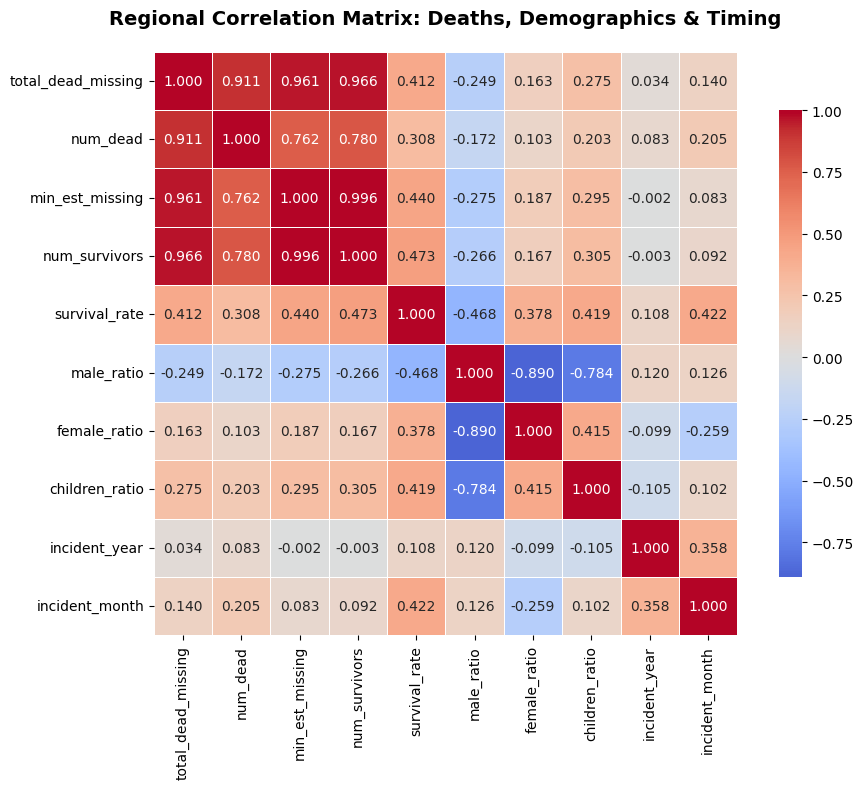

In [30]:
regional_data = df_filtered.groupby('region_incident').agg({
    'total_dead_missing': 'sum',
    'num_dead': 'sum',
    'min_est_missing': 'sum',
    'num_survivors': 'sum',
    'num_females': 'sum',
    'num_males': 'sum',
    'num_children': 'sum',
    'incident_year': 'mean',
    'incident_month': 'mean'
}).reset_index()

regional_data['survival_rate'] = regional_data['num_survivors'] / (
    regional_data['num_survivors'] + regional_data['total_dead_missing']
) * 100

regional_data['male_ratio'] = regional_data['num_males'] / (
    regional_data['num_females'] + regional_data['num_males'] + regional_data['num_children']
) * 100

regional_data['female_ratio'] = regional_data['num_females'] / (
    regional_data['num_females'] + regional_data['num_males'] + regional_data['num_children']
) * 100

regional_data['children_ratio'] = regional_data['num_children'] / (
    regional_data['num_females'] + regional_data['num_males'] + regional_data['num_children']
) * 100

# Select correlation variables
corr_vars = ['total_dead_missing', 'num_dead', 'min_est_missing', 'num_survivors', 'survival_rate', 'male_ratio', 'female_ratio', 'children_ratio', 'incident_year', 'incident_month']

regional_corr = regional_data[corr_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(regional_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Regional Correlation Matrix: Deaths, Demographics & Timing', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

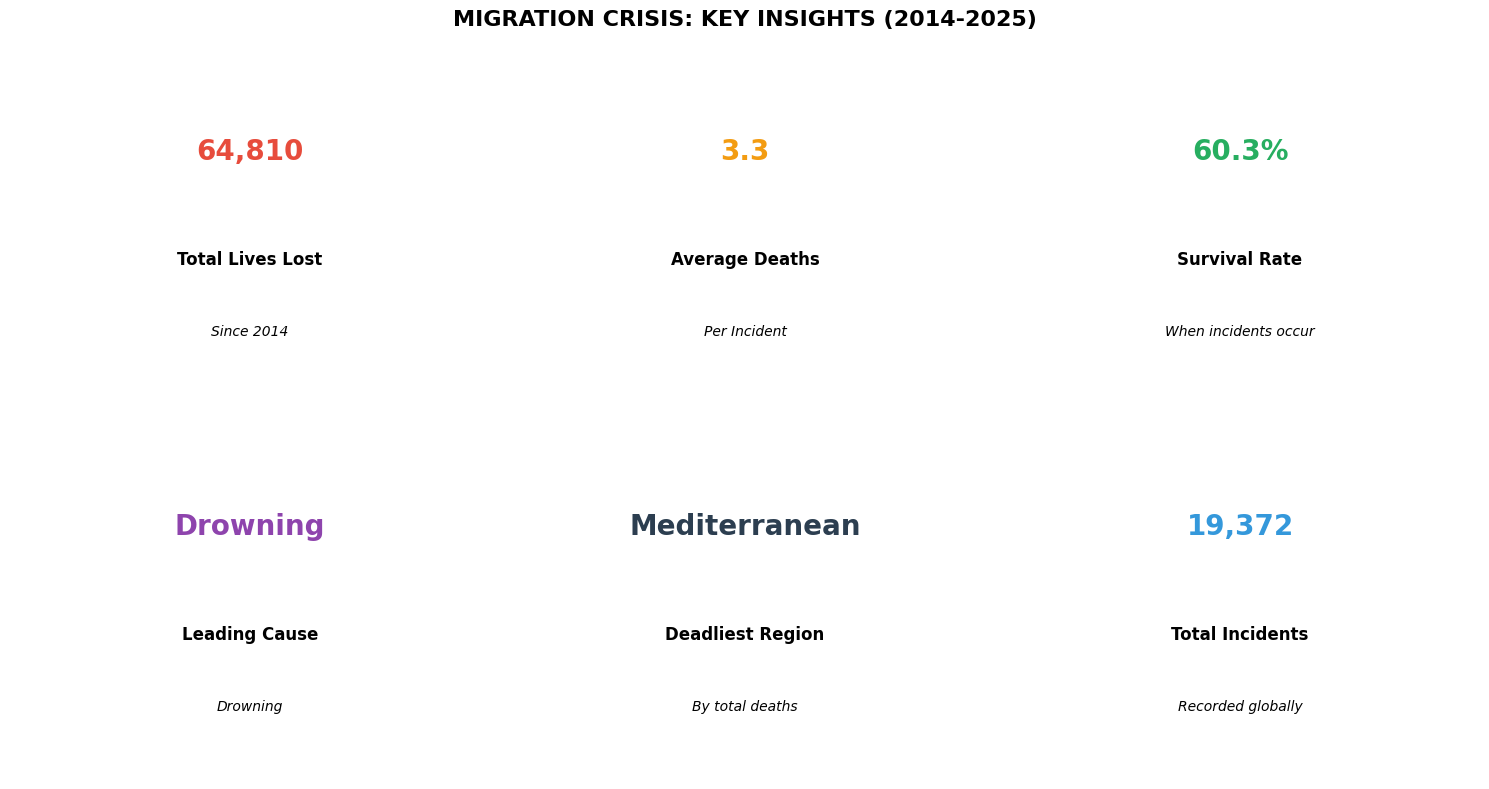

In [31]:
total_deaths = df_filtered['total_dead_missing'].sum()
avg_per_incident = df_filtered['total_dead_missing'].mean()
deadliest_cause = df_filtered.groupby('cause_death')['total_dead_missing'].sum().idxmax()
deadliest_region = df_filtered.groupby('region_incident')['total_dead_missing'].sum().idxmax()
survival_rate = df_filtered['num_survivors'].sum() / (df_filtered['num_survivors'].sum() + total_deaths) * 100

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('MIGRATION CRISIS: KEY INSIGHTS (2014-2025)', fontsize=16, fontweight='bold')

stats = [
    (f'{total_deaths:,}', 'Total Lives Lost', 'Since 2014'),
    (f'{avg_per_incident:.1f}', 'Average Deaths', 'Per Incident'),
    (f'{survival_rate:.1f}%', 'Survival Rate', 'When incidents occur'),
    (deadliest_cause.split()[0], 'Leading Cause', deadliest_cause),
    (deadliest_region, 'Deadliest Region', 'By total deaths'),
    (f'{len(df_filtered):,}', 'Total Incidents', 'Recorded globally')
]

colors = ['#e74c3c', '#f39c12', '#27ae60', '#8e44ad', '#2c3e50', '#3498db']

for i, (ax, (main_stat, title, subtitle), color) in enumerate(zip(axes.flat, stats, colors)):
    ax.text(0.5, 0.7, main_stat, ha='center', va='center', fontsize=20, fontweight='bold', color=color, transform=ax.transAxes)
    ax.text(0.5, 0.4, title, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.2, subtitle, ha='center', va='center', fontsize=10, style='italic', transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('lightgray')

plt.tight_layout()
plt.show()

## Feature Engineering

In [32]:
df_weekly_aggregated = df_filtered.groupby(['region_incident', 'incident_year', 'incident_week']).agg(
    total_dead_missing=('total_dead_missing', 'sum'),
    num_dead=('num_dead', 'sum'),
    min_est_missing=('min_est_missing', 'sum'),
    num_survivors=('num_survivors', 'sum'),
    num_females=('num_females', 'sum'),
    num_males=('num_males', 'sum'),
    num_children=('num_children', 'sum'),
    num_incidents=('incident_date', 'count'),
    most_freq_country_origin=('country_origin', lambda x: x.mode(dropna=False)[0] if not x.mode(dropna=False).empty else 'Unknown'),
    most_freq_region_origin=('region_origin', lambda x: x.mode(dropna=False)[0] if not x.mode(dropna=False).empty else 'Unknown'),
    most_freq_cause_death=('cause_death', lambda x: x.mode(dropna=False)[0] if not x.mode(dropna=False).empty else 'Unknown'),
    most_freq_country_incident=('country_incident', lambda x: x.mode(dropna=False)[0] if not x.mode(dropna=False).empty else 'Unknown'),
    most_freq_migration_route=('migration_route', lambda x: x.mode(dropna=False)[0] if not x.mode(dropna=False).empty else 'Unknown'),
).reset_index()

df_weekly_aggregated['incident_year'] = df_weekly_aggregated['incident_year'].astype(int)
df_weekly_aggregated['incident_week'] = df_weekly_aggregated['incident_week'].astype(int)

print(f"\nShape after weekly aggregation: {df_weekly_aggregated.shape}")

print("\n--- Columns after weekly aggregation ---")
print(df_weekly_aggregated.columns.tolist())

print(f"\nOriginal number of rows (after incident_date drop): {df_filtered.shape[0]}")
print(f"Number of rows after weekly aggregation (weeks with incidents): {df_weekly_aggregated.shape[0]}")


Shape after weekly aggregation: (4361, 16)

--- Columns after weekly aggregation ---
['region_incident', 'incident_year', 'incident_week', 'total_dead_missing', 'num_dead', 'min_est_missing', 'num_survivors', 'num_females', 'num_males', 'num_children', 'num_incidents', 'most_freq_country_origin', 'most_freq_region_origin', 'most_freq_cause_death', 'most_freq_country_incident', 'most_freq_migration_route']

Original number of rows (after incident_date drop): 19372
Number of rows after weekly aggregation (weeks with incidents): 4361


In [33]:
unique_regions = df_weekly_aggregated['region_incident'].unique()

min_year = df_weekly_aggregated['incident_year'].min()
max_year = df_weekly_aggregated['incident_year'].max()

all_weekly_dates = []
for year in range(min_year, max_year + 1):
    max_week_in_year = pd.to_datetime(f'{year}-12-31').isocalendar().week
    for week in range(1, max_week_in_year + 1):
        all_weekly_dates.append({'incident_year': year, 'incident_week': week})
full_weekly_date_range_df = pd.DataFrame(all_weekly_dates)

full_weekly_time_series_df = pd.merge(
    pd.DataFrame({'region_incident': unique_regions}),
    full_weekly_date_range_df,
    how='cross'
)

full_weekly_time_series_df['incident_year'] = full_weekly_time_series_df['incident_year'].astype(int)
full_weekly_time_series_df['incident_week'] = full_weekly_time_series_df['incident_week'].astype(int)

df_expanded_weekly = pd.merge(
    full_weekly_time_series_df,
    df_weekly_aggregated,
    on=['region_incident', 'incident_year', 'incident_week'],
    how='left'
)

categorical_cols_to_fill_no_incidents = [
    'most_freq_country_origin', 'most_freq_region_origin', 'most_freq_cause_death',
    'most_freq_country_incident', 'most_freq_migration_route'
]

numerical_cols_to_fill_zero = [
    'total_dead_missing', 'num_dead', 'min_est_missing',
    'num_survivors', 'num_females', 'num_males',
    'num_children', 'num_incidents',
]

for col in numerical_cols_to_fill_zero:
    if col in df_expanded_weekly.columns:
        df_expanded_weekly[col] = df_expanded_weekly[col].fillna(0)

# Fill categorical columns with 'No Incidents'
for col in categorical_cols_to_fill_no_incidents:
    if col in df_expanded_weekly.columns:
        df_expanded_weekly[col] = df_expanded_weekly[col].fillna('No Incidents')

# Sort the expanded DataFrame for correct lag/rolling calculations later
df_expanded_weekly = df_expanded_weekly.sort_values(
    by=['region_incident', 'incident_year', 'incident_week']
).reset_index(drop=True)

print(f"\nShape after filling NaNs: {df_expanded_weekly.shape}")

print("\n--- df_expanded_weekly Info after filling NaNs ---")
print(df_expanded_weekly.info())


Shape after filling NaNs: (5936, 16)

--- df_expanded_weekly Info after filling NaNs ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5936 entries, 0 to 5935
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   region_incident             5936 non-null   object 
 1   incident_year               5936 non-null   int64  
 2   incident_week               5936 non-null   int64  
 3   total_dead_missing          5936 non-null   float64
 4   num_dead                    5936 non-null   float64
 5   min_est_missing             5936 non-null   float64
 6   num_survivors               5936 non-null   float64
 7   num_females                 5936 non-null   float64
 8   num_males                   5936 non-null   float64
 9   num_children                5936 non-null   float64
 10  num_incidents               5936 non-null   float64
 11  most_freq_country_origin    5936 non-null   object 
 12  

In [34]:
weekly_high_fatality_threshold = df_expanded_weekly['total_dead_missing'].quantile(0.75)
print(f"Recalculated 75th percentile threshold for 'total_dead_missing' (weekly expanded data) is: {weekly_high_fatality_threshold:.2f}")

df_expanded_weekly['is_high_risk'] = (df_expanded_weekly['total_dead_missing'] >= weekly_high_fatality_threshold).astype(int)

print("\n--- Distribution of 'is_high_risk' target variable (Weekly) ---")
print(df_expanded_weekly['is_high_risk'].value_counts().to_string())

print("\n--- Percentage distribution of 'is_high_risk' target variable (Weekly) ---")
print(df_expanded_weekly['is_high_risk'].value_counts(normalize=True).to_string())

Recalculated 75th percentile threshold for 'total_dead_missing' (weekly expanded data) is: 5.00

--- Distribution of 'is_high_risk' target variable (Weekly) ---
is_high_risk
0    4432
1    1504

--- Percentage distribution of 'is_high_risk' target variable (Weekly) ---
is_high_risk
0    0.746631
1    0.253369


In [35]:
numerical_cols_for_lags_and_rolls = [
    'num_survivors',
    'num_incidents',
    'num_females',
    'num_males',
    'num_children',
    'num_survivors',
    'num_incidents',
]

for col in numerical_cols_for_lags_and_rolls:
    df_expanded_weekly[f'{col}_lag1'] = df_expanded_weekly.groupby('region_incident')[col].shift(1)
    df_expanded_weekly[f'{col}_lag2'] = df_expanded_weekly.groupby('region_incident')[col].shift(2)

    df_expanded_weekly[f'{col}_rolling4w_emwa'] = df_expanded_weekly.groupby('region_incident')[col].shift(1).transform(
        lambda x: x.ewm(span=4, min_periods=1).mean()
    )

lag_rolling_cols = [col for col in df_expanded_weekly.columns if '_lag' in col or '_rolling4w_emwa' in col]
for col in lag_rolling_cols:
    df_expanded_weekly[col] = df_expanded_weekly[col].fillna(0)

categorical_cols_for_lags_and_rolls = [
    'most_freq_cause_death',
    'most_freq_country_origin',
    'most_freq_region_origin',
    'most_freq_migration_route',
    'most_freq_country_incident',
]

for col in categorical_cols_for_lags_and_rolls:
    df_expanded_weekly[f'{col}_lag1'] = df_expanded_weekly.groupby('region_incident')[col].shift(1)
    df_expanded_weekly[f'{col}_lag2'] = df_expanded_weekly.groupby('region_incident')[col].shift(2)

max_week_for_cycle = df_expanded_weekly['incident_week'].max() # Will be 52 or 53
df_expanded_weekly['incident_week_sin'] = np.sin(2 * np.pi * df_expanded_weekly['incident_week'] / max_week_for_cycle)
df_expanded_weekly['incident_week_cos'] = np.cos(2 * np.pi * df_expanded_weekly['incident_week'] / max_week_for_cycle)

print("\n--- df_expanded_weekly Info after Reduced Lag and Rolling Features ---")
print(df_expanded_weekly.info())

print("\n--- First 5 rows of after adding temporal features ---")
df_expanded_weekly.head()


--- df_expanded_weekly Info after Reduced Lag and Rolling Features ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5936 entries, 0 to 5935
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   region_incident                  5936 non-null   object 
 1   incident_year                    5936 non-null   int64  
 2   incident_week                    5936 non-null   int64  
 3   total_dead_missing               5936 non-null   float64
 4   num_dead                         5936 non-null   float64
 5   min_est_missing                  5936 non-null   float64
 6   num_survivors                    5936 non-null   float64
 7   num_females                      5936 non-null   float64
 8   num_males                        5936 non-null   float64
 9   num_children                     5936 non-null   float64
 10  num_incidents                    5936 non-null   float64
 11  most_freq_

,region_incident,incident_year,incident_week,total_dead_missing,num_dead,min_est_missing,num_survivors,num_females,num_males,num_children,...,most_freq_country_origin_lag1,most_freq_country_origin_lag2,most_freq_region_origin_lag1,most_freq_region_origin_lag2,most_freq_migration_route_lag1,most_freq_migration_route_lag2,most_freq_country_incident_lag1,most_freq_country_incident_lag2,incident_week_sin,incident_week_cos
0,Caribbean,2014,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.118273,0.992981
1,Caribbean,2015,1,1.0,1.0,0.0,3.0,0.0,1.0,0.0,...,No Incidents,NaN,No Incidents,NaN,No Incidents,NaN,No Incidents,NaN,0.118273,0.992981
2,Caribbean,2015,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Cuba,No Incidents,Caribbean,No Incidents,Unknown,No Incidents,Cayman Islands,No Incidents,0.234886,0.972023
3,Caribbean,2015,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No Incidents,Cuba,No Incidents,Caribbean,No Incidents,Unknown,No Incidents,Cayman Islands,0.348202,0.937420
4,Caribbean,2015,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,No Incidents,No Incidents,No Incidents,No Incidents,No Incidents,No Incidents,No Incidents,No Incidents,0.456629,0.889657


## Model Input Preparation

In [36]:
X = df_expanded_weekly.drop(columns=[
    'total_dead_missing',
    'num_dead',
    'min_est_missing',
    'num_females',
    'num_males',
    'num_children',
    'num_survivors',
    'num_incidents',
    'most_freq_cause_death',
    'most_freq_region_origin',
    'most_freq_country_origin',
    'most_freq_migration_route',
    'most_freq_country_incident',
    'incident_week',
    'incident_year',
    'is_high_risk',
])
y = df_expanded_weekly['is_high_risk']

print("\n--- Features (X) Info ---")
print(X.info())


--- Features (X) Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5936 entries, 0 to 5935
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   region_incident                  5936 non-null   object 
 1   num_survivors_lag1               5936 non-null   float64
 2   num_survivors_lag2               5936 non-null   float64
 3   num_survivors_rolling4w_emwa     5936 non-null   float64
 4   num_incidents_lag1               5936 non-null   float64
 5   num_incidents_lag2               5936 non-null   float64
 6   num_incidents_rolling4w_emwa     5936 non-null   float64
 7   num_females_lag1                 5936 non-null   float64
 8   num_females_lag2                 5936 non-null   float64
 9   num_females_rolling4w_emwa       5936 non-null   float64
 10  num_males_lag1                   5936 non-null   float64
 11  num_males_lag2                   5936 non-null   float6

In [37]:
split_year = 2023
train_indices = df_expanded_weekly['incident_year'] < split_year
test_indices = df_expanded_weekly['incident_year'] >= split_year

X_train = X[train_indices].copy()
X_test = X[test_indices].copy()
y_train = y[train_indices].copy()
y_test = y[test_indices].copy()

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

print(f"\nX_train incident_year range: {df_expanded_weekly[train_indices]['incident_year'].min()} - {df_expanded_weekly[train_indices]['incident_year'].max()}")
print(f"X_test incident_year range: {df_expanded_weekly[test_indices]['incident_year'].min()} - {df_expanded_weekly[test_indices]['incident_year'].max()}")

Shape of X_train: (5072, 28)
Shape of X_test: (864, 28)
Shape of y_train: (5072,)
Shape of y_test: (864,)

X_train incident_year range: 2014 - 2022
X_test incident_year range: 2023 - 2025


In [38]:
categorical_cols_for_encoding = [
    'region_incident',
    'most_freq_country_origin_lag1',
    'most_freq_country_origin_lag2',
    'most_freq_region_origin_lag1',
    'most_freq_region_origin_lag2',
    'most_freq_cause_death_lag1',
    'most_freq_cause_death_lag2',
    'most_freq_country_incident_lag1',
    'most_freq_country_incident_lag2',
    'most_freq_migration_route_lag1',
    'most_freq_migration_route_lag2'
]

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

encoder = TargetEncoder(cols=categorical_cols_for_encoding, smoothing=1.0, min_samples_leaf=1)

encoder.fit(X_train_encoded, y_train)

X_train_encoded = encoder.transform(X_train_encoded)
X_test_encoded = encoder.transform(X_test_encoded)

print("\n--- Data types in X_train_encoded after Target Encoding ---")
print(X_train_encoded.info())

print("\n--- X_train_encoded head after Target Encoding ---")
X_train_encoded.head()


--- Data types in X_train_encoded after Target Encoding ---
<class 'pandas.core.frame.DataFrame'>
Index: 5072 entries, 0 to 5881
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   region_incident                  5072 non-null   float64
 1   num_survivors_lag1               5072 non-null   float64
 2   num_survivors_lag2               5072 non-null   float64
 3   num_survivors_rolling4w_emwa     5072 non-null   float64
 4   num_incidents_lag1               5072 non-null   float64
 5   num_incidents_lag2               5072 non-null   float64
 6   num_incidents_rolling4w_emwa     5072 non-null   float64
 7   num_females_lag1                 5072 non-null   float64
 8   num_females_lag2                 5072 non-null   float64
 9   num_females_rolling4w_emwa       5072 non-null   float64
 10  num_males_lag1                   5072 non-null   float64
 11  num_males_lag2            

,region_incident,num_survivors_lag1,num_survivors_lag2,num_survivors_rolling4w_emwa,num_incidents_lag1,num_incidents_lag2,num_incidents_rolling4w_emwa,num_females_lag1,num_females_lag2,num_females_rolling4w_emwa,...,most_freq_country_origin_lag1,most_freq_country_origin_lag2,most_freq_region_origin_lag1,most_freq_region_origin_lag2,most_freq_migration_route_lag1,most_freq_migration_route_lag2,most_freq_country_incident_lag1,most_freq_country_incident_lag2,incident_week_sin,incident_week_cos
0,0.164038,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.125000,0.093750,0.125000,0.093750,0.125000,0.093750,0.125000,0.093750,0.118273,0.992981
1,0.164038,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.070894,0.093750,0.070894,0.093750,0.070894,0.093750,0.070894,0.093750,0.118273,0.992981
2,0.164038,3.0,0.0,1.875000,1.0,0.0,0.625000,0.0,0.0,0.0,...,0.222222,0.069643,0.232000,0.069643,0.174129,0.069643,0.064796,0.069643,0.234886,0.972023
3,0.164038,0.0,3.0,0.918367,0.0,1.0,0.306122,0.0,0.0,0.0,...,0.070894,0.245283,0.070894,0.219512,0.070894,0.171642,0.070894,0.064796,0.348202,0.937420
4,0.164038,0.0,0.0,0.496324,0.0,0.0,0.165441,0.0,0.0,0.0,...,0.070894,0.069643,0.070894,0.069643,0.070894,0.069643,0.070894,0.069643,0.456629,0.889657


In [39]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

print("\n--- Class distribution before SMOTE ---")
print(y_train.value_counts().to_string())
print("\n--- Class distribution after SMOTE ---")
print(y_train_resampled.value_counts().to_string())

print(f"\nShape of X_train_resampled: {X_train_resampled.shape}")
print(f"Shape of y_train_resampled: {y_train_resampled.shape}")


--- Class distribution before SMOTE ---
is_high_risk
0    3850
1    1222

--- Class distribution after SMOTE ---
is_high_risk
0    3850
1    3850

Shape of X_train_resampled: (7700, 28)
Shape of y_train_resampled: (7700,)


## Baseline Model: Training, Evaluation and Feature Importances

In [40]:
rf_baseline = RandomForestClassifier(n_estimators=50, random_state=42)

rf_baseline.fit(X_train_resampled, y_train_resampled)

y_pred = rf_baseline.predict(X_test_encoded)

print("\n--- Baseline Random Forest Classifier Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

feature_importance = pd.DataFrame({
    'feature': X_train_resampled.columns,
    'importance': rf_baseline.feature_importances_ * 100
}).sort_values('importance', ascending=False)

print("\n--- Feature Importances from Random Forest ---")
print(feature_importance)


--- Baseline Random Forest Classifier Performance ---
Accuracy: 0.8044
Precision: 0.7132
Recall: 0.6702
F1 Score: 0.6910

--- Feature Importances from Random Forest ---
                            feature  importance
25  most_freq_country_incident_lag2   11.247940
22   most_freq_migration_route_lag1   10.268463
6      num_incidents_rolling4w_emwa    8.587869
0                   region_incident    6.691446
23   most_freq_migration_route_lag2    5.886417
19    most_freq_country_origin_lag2    5.565078
24  most_freq_country_incident_lag1    5.177376
15      num_children_rolling4w_emwa    4.804736
9        num_females_rolling4w_emwa    4.552313
3      num_survivors_rolling4w_emwa    4.209876
5                num_incidents_lag2    3.862470
12         num_males_rolling4w_emwa    3.817337
26                incident_week_sin    3.637129
27                incident_week_cos    3.327040
18    most_freq_country_origin_lag1    3.216799
20     most_freq_region_origin_lag1    2.588699
4             

In [41]:
top_k = 15
important_features = feature_importance.head(top_k)['feature'].tolist()

feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

print(f"Selected {len(important_features)} features:")
print(feature_importance.head(top_k).to_string(index=False))

print(f"\nCumulative importance threshold for top {top_k} features: {feature_importance['cumulative_importance'].iloc[top_k - 1]:.2f}%")

Selected 15 features:
                        feature  importance  cumulative_importance
most_freq_country_incident_lag2   11.247940              11.247940
 most_freq_migration_route_lag1   10.268463              21.516402
   num_incidents_rolling4w_emwa    8.587869              30.104271
                region_incident    6.691446              36.795718
 most_freq_migration_route_lag2    5.886417              42.682135
  most_freq_country_origin_lag2    5.565078              48.247213
most_freq_country_incident_lag1    5.177376              53.424589
    num_children_rolling4w_emwa    4.804736              58.229325
     num_females_rolling4w_emwa    4.552313              62.781638
   num_survivors_rolling4w_emwa    4.209876              66.991514
             num_incidents_lag2    3.862470              70.853984
       num_males_rolling4w_emwa    3.817337              74.671322
              incident_week_sin    3.637129              78.308450
              incident_week_cos    3.327

In [42]:
X_train_reduced = X_train_resampled[important_features]
X_test_reduced = X_test_encoded[important_features]

print(f"Shape of X_train_reduced: {X_train_reduced.shape}")
print(f"Shape of X_test_reduced: {X_test_reduced.shape}")

Shape of X_train_reduced: (7700, 15)
Shape of X_test_reduced: (864, 15)


## Hyperparameter Tuning

In [43]:
random_search_params = {
    'n_iter': 30,
    'scoring': 'f1',
    'n_jobs': 1,
    'verbose': 1,
    'random_state': 42,
    'return_train_score': True,
    'refit': True,
    'param_distributions': {
        'n_estimators': randint(50, 400),
        'max_depth': [10, 15, 20, 25, 30],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 8),
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True]
    },
}

tscv = TimeSeriesSplit(n_splits=5)
rf_classifier = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf_classifier, cv=tscv, **random_search_params)

random_search.fit(X_train_reduced, y_train_resampled)

print("\n--- Best Parameters from Random Search ---")
print(random_search.best_params_)
print(f"\n--- Best CV Score: {random_search.best_score_:.4f} ---")

best_model = random_search.best_estimator_

now = datetime.datetime.now()
unix_timestamp = int(now.timestamp())
readable_timestamp = now.strftime('%d-%m-%Y_%H-%M-%S') # Example: '01-01-2024_12-00-00'
with open(f'models/best_model_{readable_timestamp}_{unix_timestamp}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

--- Best Parameters from Random Search ---
{'bootstrap': True, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 363}

--- Best CV Score: 0.8233 ---


In [44]:

def load_best_model():
    model_files = glob.glob(f'models/best_model_*.pkl')

    if not model_files:
        raise FileNotFoundError(f"No saved models found.")

    latest_model_file = max(model_files, key=lambda x: int(x.split('_')[-1].replace('.pkl', '')))

    with open(latest_model_file, 'rb') as f:
        print(f"Loading model from: {latest_model_file}")
        model = pickle.load(f)

    return model

best_model = load_best_model()

Loading model from: models/best_model_1754152952.pkl


## Results

In [45]:
y_pred = best_model.predict(X_test_reduced)

print("\n--- Best Model Performance on Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


--- Best Model Performance on Test Set ---
Accuracy: 0.8125
Precision: 0.7128
Recall: 0.7128
F1 Score: 0.7128


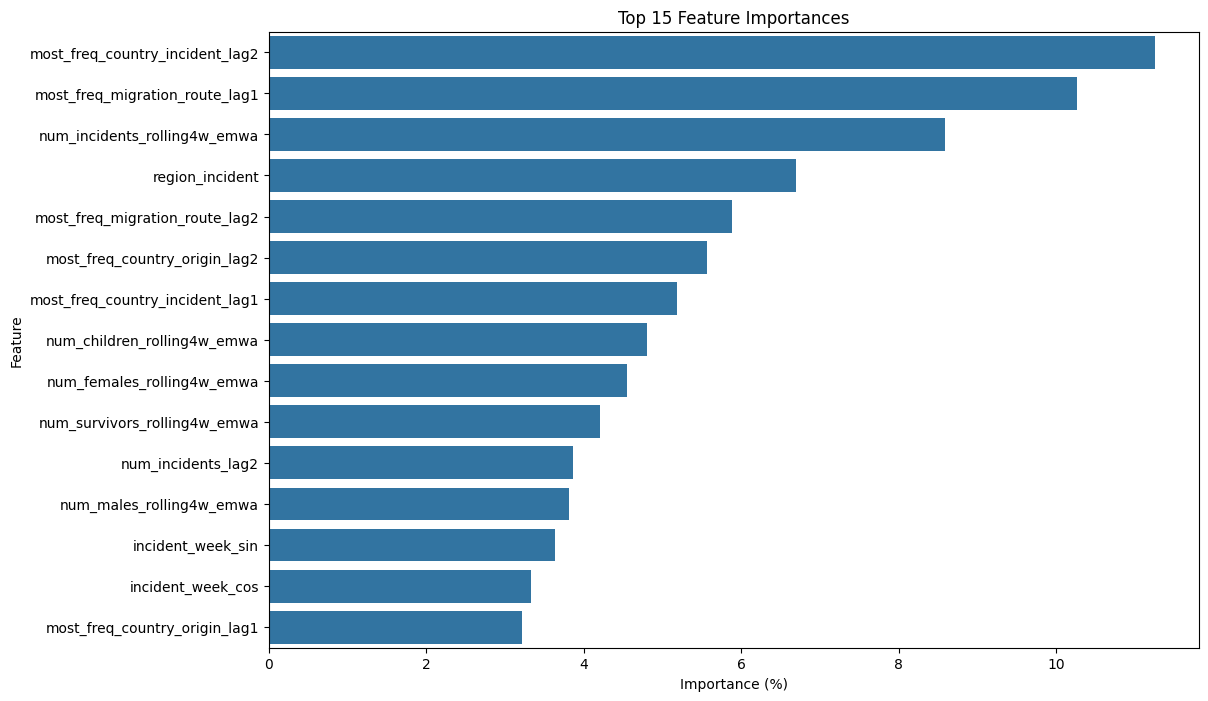


--- Top 10 Features and Their Importance ---
                        feature  importance  cumulative_importance
most_freq_country_incident_lag2   11.247940              11.247940
 most_freq_migration_route_lag1   10.268463              21.516402
   num_incidents_rolling4w_emwa    8.587869              30.104271
                region_incident    6.691446              36.795718
 most_freq_migration_route_lag2    5.886417              42.682135
  most_freq_country_origin_lag2    5.565078              48.247213
most_freq_country_incident_lag1    5.177376              53.424589
    num_children_rolling4w_emwa    4.804736              58.229325
     num_females_rolling4w_emwa    4.552313              62.781638
   num_survivors_rolling4w_emwa    4.209876              66.991514


In [46]:
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(top_k))
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.show()

print("\n--- Top 10 Features and Their Importance ---")
print(feature_importance.head(10).to_string(index=False))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       582
           1       0.71      0.71      0.71       282

    accuracy                           0.81       864
   macro avg       0.79      0.79      0.79       864
weighted avg       0.81      0.81      0.81       864



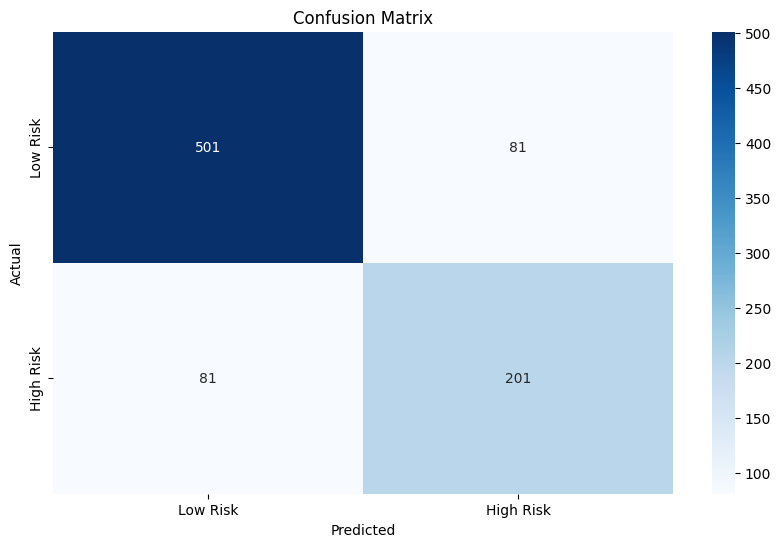

In [47]:
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Low Risk', 'High Risk'],
    yticklabels=['Low Risk', 'High Risk']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [48]:
# TODO:
# given region and week - predict the risk level
# given range of date - give me all high risk regions

In [49]:
X_test_with_predictions = X_test_reduced.copy()

X_test_with_predictions['is_high_risk_predicted'] = y_pred

X_test_with_predictions = X_test_with_predictions.sort_values(by=['is_high_risk_predicted', 'region_incident'], ascending=False)

X_test_with_predictions = X_test_with_predictions.reset_index(drop=True)

X_test_with_predictions.head(10)

,most_freq_country_incident_lag2,most_freq_migration_route_lag1,num_incidents_rolling4w_emwa,region_incident,most_freq_migration_route_lag2,most_freq_country_origin_lag2,most_freq_country_incident_lag1,num_children_rolling4w_emwa,num_females_rolling4w_emwa,num_survivors_rolling4w_emwa,num_incidents_lag2,num_males_rolling4w_emwa,incident_week_sin,incident_week_cos,most_freq_country_origin_lag1,is_high_risk_predicted
0,0.721311,0.741379,5.046545,0.791798,0.824561,0.559140,0.661290,1.307432,1.815738,117.374183,5.0,1.841959,0.118273,0.992981,0.559024,1
1,0.721311,0.810000,4.227927,0.791798,0.824561,0.559140,0.740458,0.784459,1.089443,148.824510,5.0,1.905175,0.234886,0.972023,0.559024,1
2,0.762452,0.810000,4.536756,0.791798,0.790000,0.559140,0.740458,0.470675,0.653666,89.294706,3.0,1.943105,0.348202,0.937420,0.559024,1
3,0.762452,0.810000,4.322054,0.791798,0.790000,0.559140,0.740458,0.282405,0.392199,53.576823,5.0,1.565863,0.456629,0.889657,0.559024,1
4,0.762452,0.810000,4.593232,0.791798,0.790000,0.559140,0.640000,0.169443,1.035320,95.746094,4.0,1.739518,0.558647,0.829406,0.559024,1
5,0.620000,0.857143,4.355939,0.791798,0.790000,0.559140,0.525424,0.101666,0.621192,75.447656,5.0,2.243711,0.652822,0.757511,0.211765,1
6,0.525424,0.810000,3.413564,0.791798,0.857143,0.211765,0.525424,0.061000,0.372715,60.868594,4.0,1.746226,0.737833,0.674983,0.559024,1
7,0.525424,0.810000,3.248138,0.791798,0.790000,0.559140,0.444444,0.436600,1.023629,58.121156,2.0,7.847736,0.812487,0.582979,0.285604,1
8,0.407407,0.810000,3.548883,0.791798,0.790000,0.285604,0.444444,0.261960,1.014177,64.472694,3.0,4.708642,0.875735,0.482792,0.559024,1
9,0.407407,0.810000,3.329330,0.791798,0.790000,0.559140,0.525424,2.557176,2.208506,51.083616,4.0,5.225185,0.926690,0.375828,0.590909,1
